# Exploring the Knowledge Graph

### Definition of functions to access, query and plot the knowledge graph/subgraphs

In [4]:
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def getGraphDatabaseConnectionConfiguration():
    host = config.dbURL
    port = config.dbPort
    user = config.dbUser
    password = config.dbPassword

    driver = connectToDB(host, port, user, password)

    return driver

def connectToDB(host = "localhost", port= 7687, user="neo4j", password = "password"):
    driver = Graph(host=host, port = port, user = user, password = password)

    return driver

def simplePlotGraph(graph):
    G=nx.Graph()
    for rel in graph["relationships"]:
        snode = rel.start_node()
        enode = rel.end_node()
        if "name" in snode and "name" in enode:
            G.add_edge(snode["name"],enode["name"], label=rel.type())
    plt.figure(3,figsize=(25,25)) 
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos,node_size=260,font_size=16)
    plt.axis('off')
    plt.show()
    
def getCursorData(cursor, header):
    df = pd.DataFrame(cursor)
    return df

### Definition of Cypher queries to extract information from the graph

In [21]:
dbstats_queries = {"num_nodes":'''MATCH (n) RETURN count(n);''',
           "num_relationships":'''MATCH ()-->() RETURN count(*);''',
           "type_nodes":'''MATCH (n) WHERE rand() <= 0.1
                           RETURN
                           DISTINCT labels(n),
                           count(*) AS SampleSize,avg(size(keys(n))) as Avg_PropertyCount, 
                           min(size(keys(n))) as Min_PropertyCount,
                           max(size(keys(n))) as Max_PropertyCount,
                           avg(size( (n)-[]-() ) ) as Avg_RelationshipCount,
                           min(size( (n)-[]-() ) ) as Min_RelationshipCount,
                           max(size( (n)-[]-() ) ) as Max_RelationshipCount;''',
           "schema":'''CALL db.schema();'''}
project_queries = {"existing_projects": '''MATCH (n:Project) RETURN n.name AS Name, n.acronym AS acronym, n.responsible AS Responsible''',
                  "subjects": '''MATCH (p:Project)-[r:HAS_ENROLLED]->(s:Subject) RETURN p.name AS Project, s.id AS Id, s.external_id AS External'''}
analytical_samples = {"proteins": '''MATCH (a:Analytical_sample{id:"IDENTIFIER"})-[r:HAS_QUANTIFIED_PROTEIN]->(p:Protein) 
                                    RETURN a.id AS Analytical_sampleId, p.id AS ProteinId, p.name AS Name, 
                                    p.synonyms AS Synonyms, r.value AS Intensity LIMIT 25''',
                     "peptides": '''MATCH (a:Analytical_sample{id:"IDENTIFIER"})-[r:HAS_QUANTIFIED_PEPTIDE]->(p:Peptide) 
                                    RETURN a.id AS Analytical_sampleId, p.id AS PeptideId, p.name AS Name, 
                                    r.value AS Intensity LIMIT 25''',
                     "ptm": '''MATCH (a:Analytical_sample{id:"IDENTIFIER"})-[r:HAS_QUANTIFIED_PROTEINMODIFICATION]->(p:Modified_protein) 
                             RETURN a.id AS Analytical_sampleId, p.id AS PTMId, 
                             p.protein AS Protein, p.position AS position , p.residue as Residue LIMIT 25'''}
mentions_queries = {"disease":'''MATCH (d:Disease{id:"DISEASE"})-[r:MENTIONED_IN_PUBLICATION]->(pubmed:Publication) RETURN d.id AS Id, d.name AS Name, pubmed.id AS PUBMEDID LIMIT 25'''}
variant_queries = {"subject":'''MATCH (a:Analytical_sample)-[r:CALLED_VARIANT]->(s:Somatic_mutation) RETURN a.id AS AnalyticalSampleId, s.id AS SomaticMutationId  LIMIT 25'''}

## Connect to the graph

In [6]:
graph = connectToDB( user="neo4j", password = "bioinfo1112")

### Access some of the graph statistics

In [7]:
getCursorData(cursor = graph.run(dbstats_queries["num_nodes"]).data(), header = ["Number of Nodes"])

,count(n)
0,11423852


In [8]:
getCursorData(cursor = graph.run(dbstats_queries["num_relationships"]).data(), header = ["Number of Relationships"])

,count(*)
0,8764654


In [9]:
getCursorData(cursor = graph.run(dbstats_queries["type_nodes"]).data(), header = ["Types"])

,Avg_PropertyCount,Avg_RelationshipCount,Max_PropertyCount,Max_RelationshipCount,Min_PropertyCount,Min_RelationshipCount,SampleSize,labels(n)
0,5.000000,0.014245,5,46,5,0,5265,[Clinical_variable]
1,5.000000,0.997766,5,558,5,0,21035,[Drug]
2,3.000000,27.363360,3,79,3,2,988,[Modified_protein]
3,5.000000,15.812230,5,8189,5,0,4170,[Gene]
4,3.000000,57.287129,3,1449,3,1,202,[Pathway]
5,2.000000,2.000000,2,2,2,2,14,[Subject]
6,2.000000,16.000000,2,16,2,16,12,[Biological_sample]
7,5.000000,39.834554,5,6577,5,2,3004,[Biological_process]
8,3.000000,14228.750000,3,19824,3,8509,4,[Chromosome]
9,1.000000,0.000000,1,0,1,0,1,[Manufacturer]


### Plot the data model

/Users/albertosantos/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:520: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/albertosantos/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:541: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/albertosantos/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:722: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


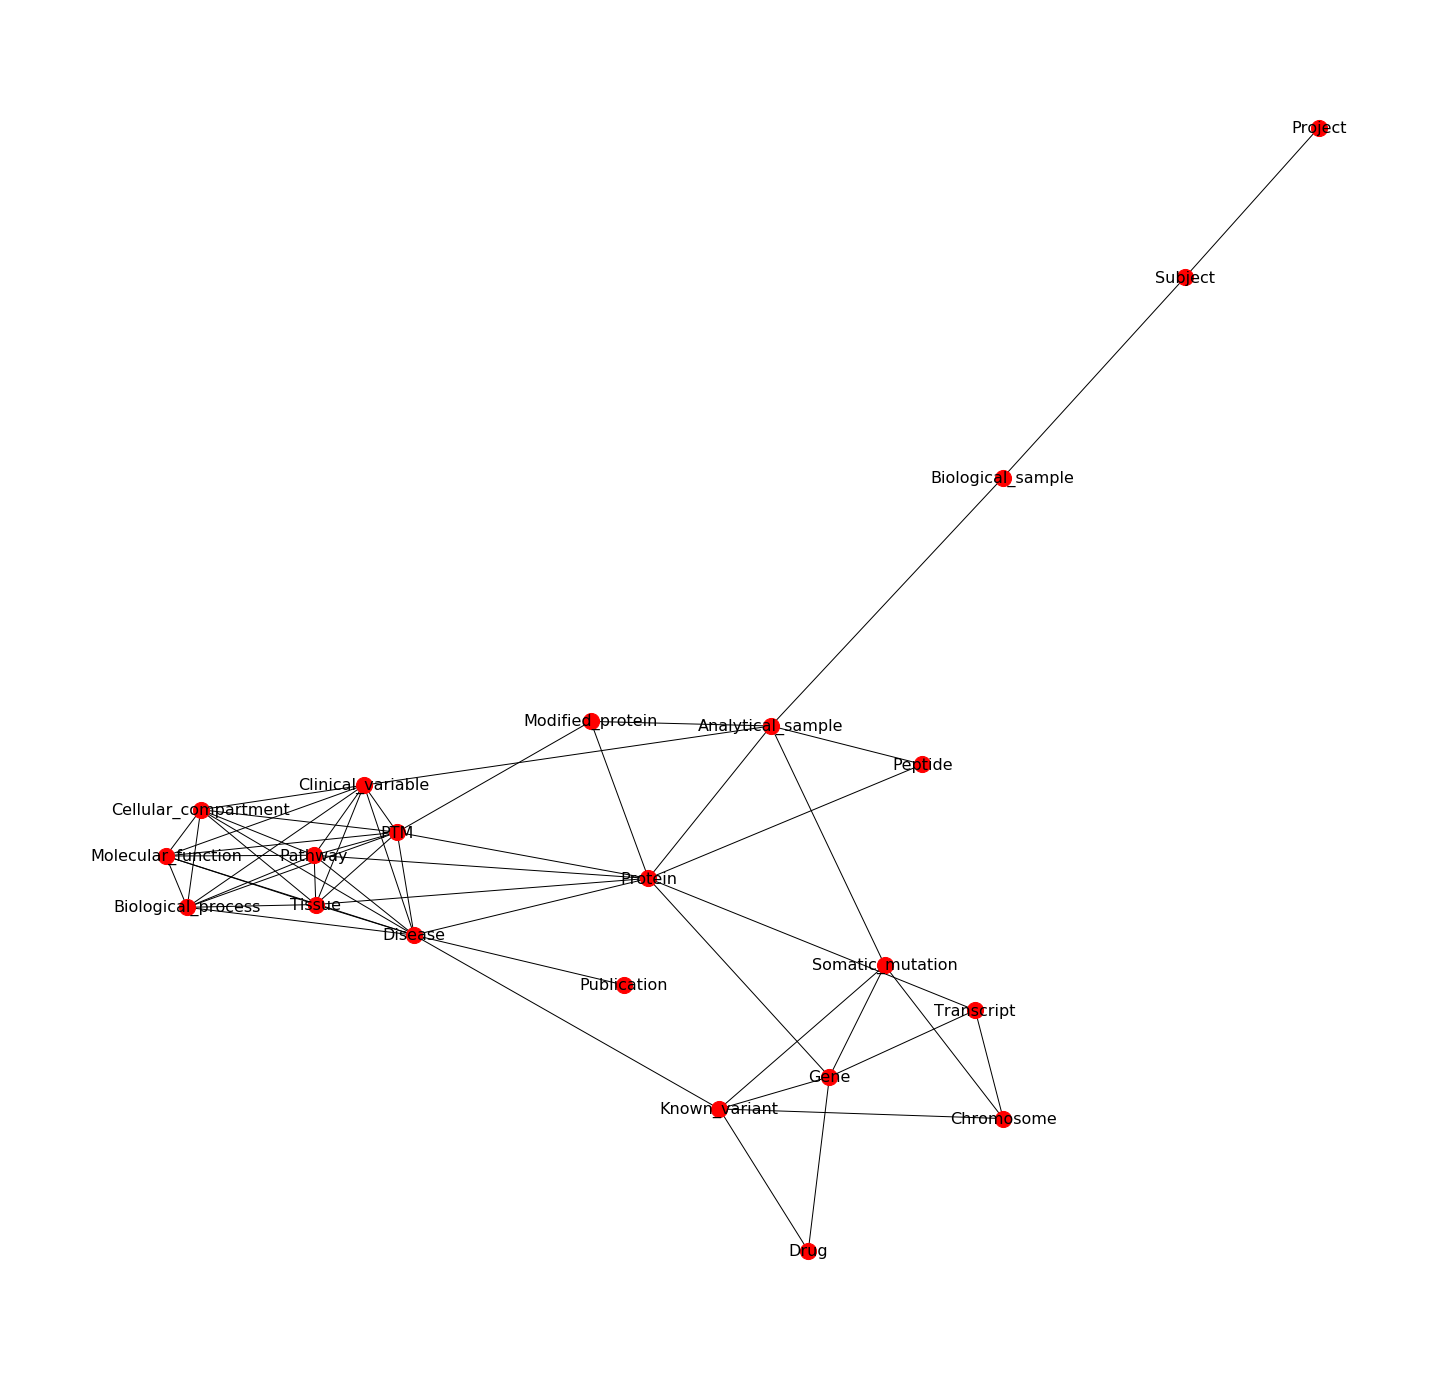

In [10]:
subgraph = graph.run(dbstats_queries["schema"]).data()[0]
simplePlotGraph(subgraph)

### Projects already in the database

In [11]:
getCursorData(cursor = graph.run(project_queries["existing_projects"]).data(), header = ["Types"])

,Name,Responsible,acronym
0,NAFLD,None,Non-alcoholic Fatty Liver Disease
1,CaseStudyUrachal,Sophia Doll,CSU


In [12]:
getCursorData(cursor = graph.run(project_queries["subjects"]).data(), header = ["Types"]).set_index(["Project", "Id"]).sort_values(by="External")

External
Project          Id          
NAFLD            S1         1
                 S10       10
                 S11       11
                 S12       12
                 S13       13
                 S14       14
                 S15       15
                 S16       16
                 S17       17
                 S18       18
                 S19       19
                 S2         2
                 S20       20
                 S21       21
                 S22       22
                 S23       23
                 S24       24
                 S25       25
                 S26       26
                 S27       27
                 S28       28
                 S3         3
                 S29       30
                 S30       31
                 S31       32
                 S32       33
                 S33       34
                 S34       35
                 S35       36
                 S36       37
...                       ...
                 S53       54
                 S54       55
                 S55       56
                 S56       57
                 S57       58
                 S58       59
                 S6         6
                 S59       60
                 S60       61
                 S61       62
                 S62       63
                 S63       64
                 S64       65
                 S65       66
                 S66       67
                 S67       68
                 S68       69
                 S7         7
                 S69       70
                 S70       71
                 S71       72
                 S72       73
                 S73       74
                 S74       75
                 S75       76
                 S76       77
                 S77       78
                 S8         8
                 S9         9
CaseStudyUrachal S78   uro_s2

[78 rows x 1 columns]

In [15]:
getCursorData(cursor = graph.run(analytical_samples["proteins"].replace("IDENTIFIER", "AS22")).data(), header = ["Types"]).set_index(["Analytical_sampleId", "ProteinId"]).sort_values(by="Name")

Intensity        Name  \
Analytical_sampleId ProteinId                            
AS22                Q9UL94     8.166912888               
                    X6RLJ0     8.825018098        C1QA   
                    V9HWP2     7.017325555  HEL-S-125m   
                    V9HWG1     7.451740395  HEL-S-134P   
                    V9HWP0     9.783982145   HEL-S-92n   
                    X2KYV2      7.35302808       HLA-A   
                    W6SNC0      7.35302808       HLA-A   
                    W0T236      7.35302808       HLA-A   
                    W0UTP4      7.35302808       HLA-A   
                    W0NT88      7.35302808       HLA-A   
                    W0NTM2      7.35302808       HLA-A   
                    W0FF27      7.35302808       HLA-A   
                    W0NQ20      7.35302808       HLA-A   
                    X2KYR1      7.35302808       HLA-A   
                    V9VYY9      7.35302808       HLA-A   
                    X5MNS3      7.35302808       HLA-A   
                    X5MBH5      7.35302808       HLA-A   
                    X5MPH1      7.35302808       HLA-A   
                    W8NKY4      7.35302808       HLA-A   
                    W8E988      7.35302808       HLA-A   
                    W6SQV0      7.35302808       HLA-A   
                    X2KXS0      7.35302808       HLA-A   
                    W1I6E7      7.35302808       HLA-A   
                    X5D2Q8     7.218172246        NRP2   
                    X5D7M1     7.218172246        NRP2   

                                                            Synonyms  
Analytical_sampleId ProteinId                                         
AS22                Q9UL94                            [Q9UL94_HUMAN]  
                    X6RLJ0     [X6RLJ0_HUMAN, C1QA, ENSG00000173372]  
                    V9HWP2                [V9HWP2_HUMAN, HEL-S-125m]  
                    V9HWG1                [V9HWG1_HUMAN, HEL-S-134P]  
                    V9HWP0                 [V9HWP0_HUMAN, HEL-S-92n]  
                    X2KYV2                     [X2KYV2_HUMAN, HLA-A]  
                    W6SNC0                     [W6SNC0_HUMAN, HLA-A]  
                    W0T236                     [W0T236_HUMAN, HLA-A]  
                    W0UTP4                     [W0UTP4_HUMAN, HLA-A]  
                    W0NT88                     [W0NT88_HUMAN, HLA-A]  
                    W0NTM2                     [W0NTM2_HUMAN, HLA-A]  
                    W0FF27                     [W0FF27_HUMAN, HLA-A]  
                    W0NQ20                     [W0NQ20_HUMAN, HLA-A]  
                    X2KYR1                     [X2KYR1_HUMAN, HLA-A]  
                    V9VYY9                     [V9VYY9_HUMAN, HLA-A]  
                    X5MNS3                     [X5MNS3_HUMAN, HLA-A]  
                    X5MBH5                     [X5MBH5_HUMAN, HLA-A]  
                    X5MPH1                     [X5MPH1_HUMAN, HLA-A]  
                    W8NKY4                     [W8NKY4_HUMAN, HLA-A]  
                    W8E988                     [W8E988_HUMAN, HLA-A]  
                    W6SQV0                     [W6SQV0_HUMAN, HLA-A]  
                    X2KXS0                     [X2KXS0_HUMAN, HLA-A]  
                    W1I6E7                     [W1I6E7_HUMAN, HLA-A]  
                    X5D2Q8     [X5D2Q8_HUMAN, NRP2, ENSG00000118257]  
                    X5D7M1                      [X5D7M1_HUMAN, NRP2]

In [16]:
getCursorData(cursor = graph.run(analytical_samples["peptides"].replace("IDENTIFIER", "AS22")).data(), header = ["Types"]).set_index(["Analytical_sampleId", "PeptideId"]).sort_values(by="Name")

Intensity  Name
Analytical_sampleId PeptideId                            
AS22                LLIYGASSR           9.115310895  None
                    LLIYGASIR           8.330596382  None
                    LLIYGAFSR           7.482044204  None
                    LLIYESDK            7.010342366  None
                    LLIYDTSYR            7.16964903  None
                    LLIYDNNK            8.428264415  None
                    LLIYDASSR            8.82995312  None
                    LLIYDASSLESGVPSR    6.688521123  None
                    LLIYDASNR           9.117933835  None
                    LLIYDASNLK          7.808069112  None
                    LLIYDASNLGTGVPSR    7.060340828  None
                    LLIYDASNLETGVPSR    8.737701408  None
                    LLIYDASDLETGVPSR    7.450987705  None
                    LLIYAVLPTGDVIGDSAK  9.708922047  None
                    LLIYATSSLQSGVPSR    7.973026198  None
                    LLIYAASTLQSGVPSR    8.313276516  None
                    LLIYAASGLQSGVPSR    6.926445348  None
                    LLIYAASSLQSGVPSR    8.272607333  None
                    LLIGTVFHK           8.976363737  None
                    LLISAASTLQSGVPSR    7.520588327  None
                    LLGLSLAGK           7.115144352  None
                    LLGMETMAWQEIR       8.001030506  None
                    LLGEVGTLQFAELHR     6.153608449  None
                    LLGIETPLPK           6.55367537  None
                    LLGELLQDNAK         6.692221014  None

In [17]:
getCursorData(cursor = graph.run(analytical_samples["ptm"].replace("IDENTIFIER", "AS22")).data(), header = ["Types"]).set_index(["Analytical_sampleId", "PTMId"]).sort_values(by="Protein")

Protein Residue position
Analytical_sampleId PTMId                                        
AS22                A0A024CIM4_582M   A0A024CIM4    None      582
                    A0A024CIM4_560M   A0A024CIM4    None      560
                    A0A024QZL1_157M   A0A024QZL1    None      157
                    A0A024QZN4_94M    A0A024QZN4    None       94
                    A0A024QZN4_898M   A0A024QZN4    None      898
                    A0A024R0T8_64M    A0A024R0T8    None       64
                    A0A024R0T9_82M    A0A024R0T9    None       82
                    A0A024R141_250M   A0A024R141    None      250
                    A0A024R145_329M   A0A024R145    None      329
                    A0A024R1A3_1015M  A0A024R1A3    None     1015
                    A0A024R1G8_345M   A0A024R1G8    None      345
                    A0A024R1N1_1678M  A0A024R1N1    None     1678
                    A0A024R1Q4_60M    A0A024R1Q4    None       60
                    A0A024R1X8_43M    A0A024R1X8    None       43
                    A0A024R321_491M   A0A024R321    None      491
                    A0A024R3E3_172M   A0A024R3E3    None      172
                    A0A024R3E3_136M   A0A024R3E3    None      136
                    A0A024R3E3_110M   A0A024R3E3    None      110
                    A0A024R462_210M   A0A024R462    None      210
                    A0A024R462_209M   A0A024R462    None      209
                    A0A024R462_926M   A0A024R462    None      926
                    A0A024R462_463M   A0A024R462    None      463
                    A0A024R462_1783M  A0A024R462    None     1783
                    A0A024R610_836M   A0A024R610    None      836
                    A0A024R6I6_431M   A0A024R6I6    None      431

In [20]:
df = getCursorData(cursor = graph.run(mentions_queries["disease"].replace("DISEASE", "DOID:0014667")).data(), header = ["Types"]).set_index(["Id", "Name"]).sort_values(by="PUBMEDID")
df["linkout"] = "https://www.ncbi.nlm.nih.gov/pubmed/"+df["PUBMEDID"]
df

PUBMEDID  \
Id           Name                             
DOID:0014667 disease of metabolism   168953   
             disease of metabolism   169686   
             disease of metabolism   169689   
             disease of metabolism   169840   
             disease of metabolism   169947   
             disease of metabolism   170030   
             disease of metabolism   170108   
             disease of metabolism   170154   
             disease of metabolism   170155   
             disease of metabolism   170190   
             disease of metabolism   170191   
             disease of metabolism   170283   
             disease of metabolism   170294   
             disease of metabolism   170349   
             disease of metabolism   170451   
             disease of metabolism   170484   
             disease of metabolism   170494   
             disease of metabolism   170497   
             disease of metabolism   170514   
             disease of metabolism   170516   
             disease of metabolism   170547   
             disease of metabolism   170559   
             disease of metabolism   232678   
             disease of metabolism   232901   
             disease of metabolism   232912   

                                                                       linkout  
Id           Name                                                               
DOID:0014667 disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/168953  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/169686  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/169689  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/169840  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/169947  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170030  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170108  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170154  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170155  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170190  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170191  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170283  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170294  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170349  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170451  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170484  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170494  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170497  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170514  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170516  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170547  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/170559  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/232678  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/232901  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/232912

In [24]:
getCursorData(cursor = graph.run(variant_queries["subject"]).data(), header = ["Types"]).set_index(["AnalyticalSampleId", "SomaticMutationId"])

Empty DataFrame
Columns: []
Index: [(AS78, chrY:g.13312413G>A), (AS78, chrX:g.153225006A>G), (AS78, chrX:g.135252045T>A), (AS78, chrX:g.112022644A>G), (AS78, chrX:g.83116144G>T), (AS78, chr22:g.21570340G>A), (AS78, chr22:g.21663645C>T), (AS78, chr22:g.16886078C>T), (AS78, chr22:g.17001556G>A), (AS78, chr22:g.16426855G>T), (AS78, chr22:g.16886074T>C), (AS78, chr21:g.46355833A>G), (AS78, chr21:g.47417636C>G), (AS78, chrX:g.24447709G>C), (AS78, chrX:g.41782296G>C), (AS78, chr22:g.50753973T>C), (AS78, chrX:g.8434522T>A), (AS78, chr22:g.32666087C>T), (AS78, chr22:g.50167865G>A), (AS78, chr22:g.24656950C>T), (AS78, chr22:g.26239822C>T), (AS78, chr19:g.53656693T>A), (AS78, chr19:g.51518060T>C), (AS78, chr19:g.55263717G>C), (AS78, chr19:g.54657685C>T)]